# Sth title

## Introduction


In [2]:
import inspect
from data_loader import *
from model import *
from analysis import *

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## Data

### Images dataset
The provided data consists of two sets of aerial photographies – _NIR_ and _RED_. The directory with data is structured as follows:
```
dataset-v11
├── test
│   ├── NIR
│   │   ├── imageset0001
│   │   │   ├── HR000.png
│   │   │   ├── LR000.png
│   │   │   ├── QM000.png
│   │   │   ⋮
│   │   ⋮
│   │   
│   └── RED
│       ⋮
│
└── train
    ├── NIR
    │   ⋮
    │
    └── RED
        ⋮
```
Photos are 14-bit, grayscale images. In the dataset structure _imageset_ denotes a scene, which contains photos of the same landmark. Photos with the same index within scene were taken simultaneously. It is possible to use whole scene or just one sample per scene. Photos marked as _HR_ are high resolution – 378 by 378 pixels, whereas _LR_ are low resolution – 126 by 126 pixels; 3 times smaller. There are additional _QM_ masks, that mark areas covered by clouds. Using masks may be considered to alleviate the noise introduced by the clouds. Due to the task being to make network transforming _HR_ into _LR_ images, they will be called _x_ and _y_ respecively. One should notice that _HR_ and _LR_ come from different cameras making photos and are not the same image being rescaled. This results in images being sometimes slightly shifted.

### Data loading and storing
The number of photos in dataset is quite big. Also there is need for some code for recursing and browsing dataset, choosing _NIR_ or _RED_ and choosing number of images per scene. Because of this loading images takes some time. Data loading and processing code is located in the `data_loader.py` file. By default it loads images into _numpy_ arrays and saves them as `.npy` files, each of which contains one imageset prepared for training a neural network. Each image is loaded taking 14-bits depth into consideration and stored as a float inside the `.npy`.

The '.npy' files are data strucure that looks like:
```
[ [train_hr, train_lr, train_lr_masks],
  [test_hr, test_lr, test_lr_masks] ]
```
These files are created for both _NIR_ and _RED_, with one image per scene variants. The `data_loader.py` also provides some functions for transforming _x_ and _y_ parts of datasets as well as only _y_. This will come in handy later during comparisons and analysis.

## Neural network
The default network model and training code are placed into `model.py`.

### Model
The neural network is very simple CNN that shrinks images by using convolution with proper stride size. The default model looks like this:

In [8]:
print(inspect.getsource(make_model))

def make_model():
    model = models.Sequential()

    model.add(layers.InputLayer(input_shape=(378, 378, 1)))
    model.add(layers.Conv2D(64, kernel_size=3,
                            padding='same', activation='relu'))
    model.add(layers.Conv2D(64, kernel_size=5, strides=3,
                            padding='same', activation='relu'))
    model.add(layers.Conv2D(1, kernel_size=3,
                            padding='same', activation='sigmoid'))
    return model



This rudimentary model has enough capacity to learn common resizng/resampling algorithms such as bilinear and bicubic. Some more complex designs were tested (autoencoders), but just for resizing photos, the bare bones network is enough.

### Training
The network is trained as follows:


In [4]:
print(inspect.getsource(train))

def train(npy_data_path):
    x_train, y_train, x_test, y_test = make_data(npy_data_path)
    model = make_model()
    callbacks = make_callbacks(earlystopping=False)

    model.compile(loss=losses.MeanSquaredError(),
                  optimizer=optimizers.Adam(),
                  metrics=['mae'])

    model.summary()

    model.fit(x_train, y_train,
              validation_split=0.2,
              epochs=1,
              callbacks=callbacks)
    return model



### Notes on model
After training model one can notice that it produces a bit more blurry objects than one may exptect. This is due to the bias in the exporsure of _x_ and _y_ data, which may seem rather random, but the average exporsure between _HR_ and _LR_ is slightly shifted. This results in the network trying to do two things: downscale image and shift overall exposure. The latter makes result more blurry.

This was mitigated by equalizing histogram on whole dataset when training. The network trained this way can be used on real (not equalized) images and produce more visually pleasing results. Because of dataset modification it is pointless to compare loss after such modification. However the increase in quality is visible in later section when results are compared to standard resizing algorithms.

## Comparison

### NIR

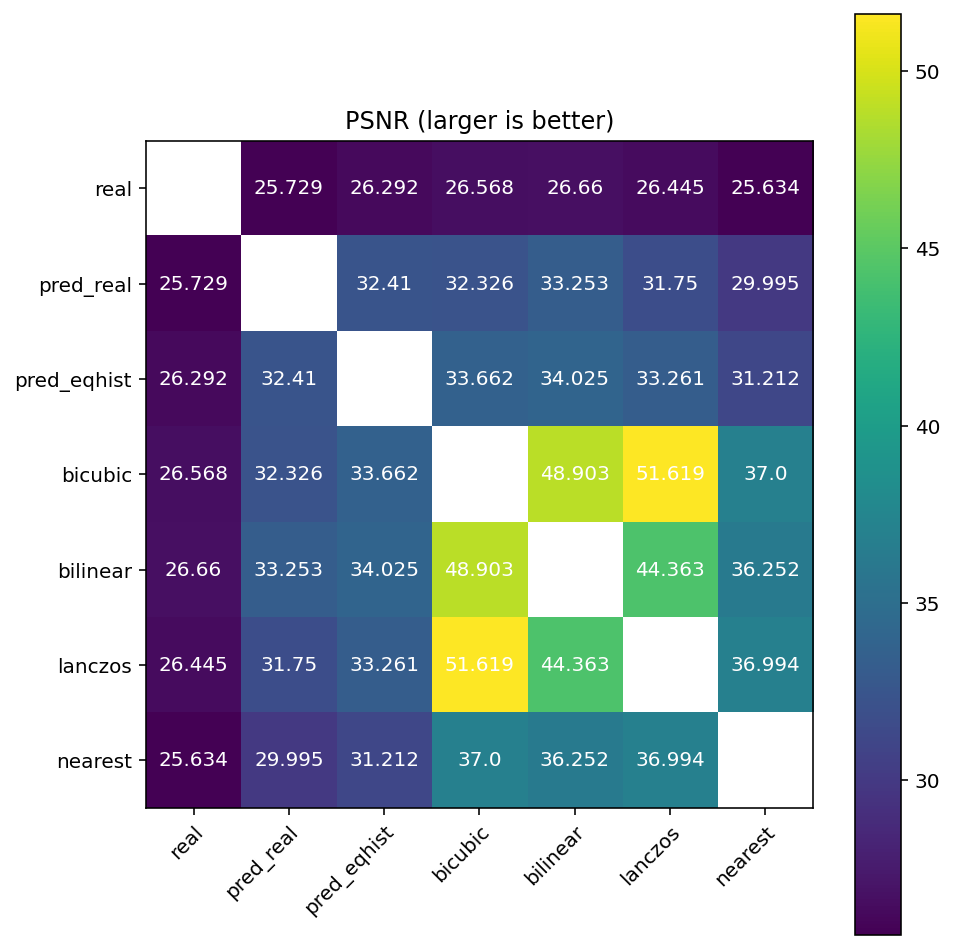

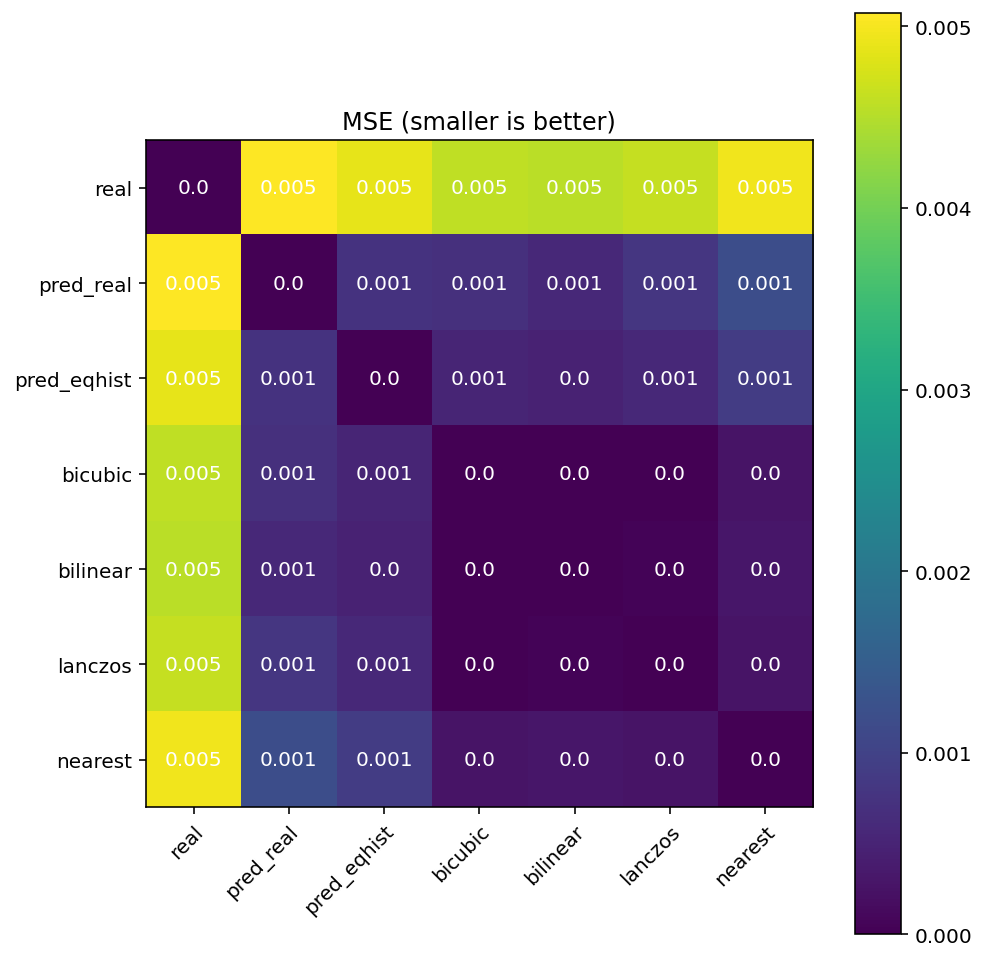

In [5]:
demo_heatmap('data/dat-nir-one-per-scene.npy',
             ('log/model-20-07-22-10:54:06-nir-real.h5',
              'log/model-20-07-21-19:19:49-nir-eqhist.h5'))

### RED

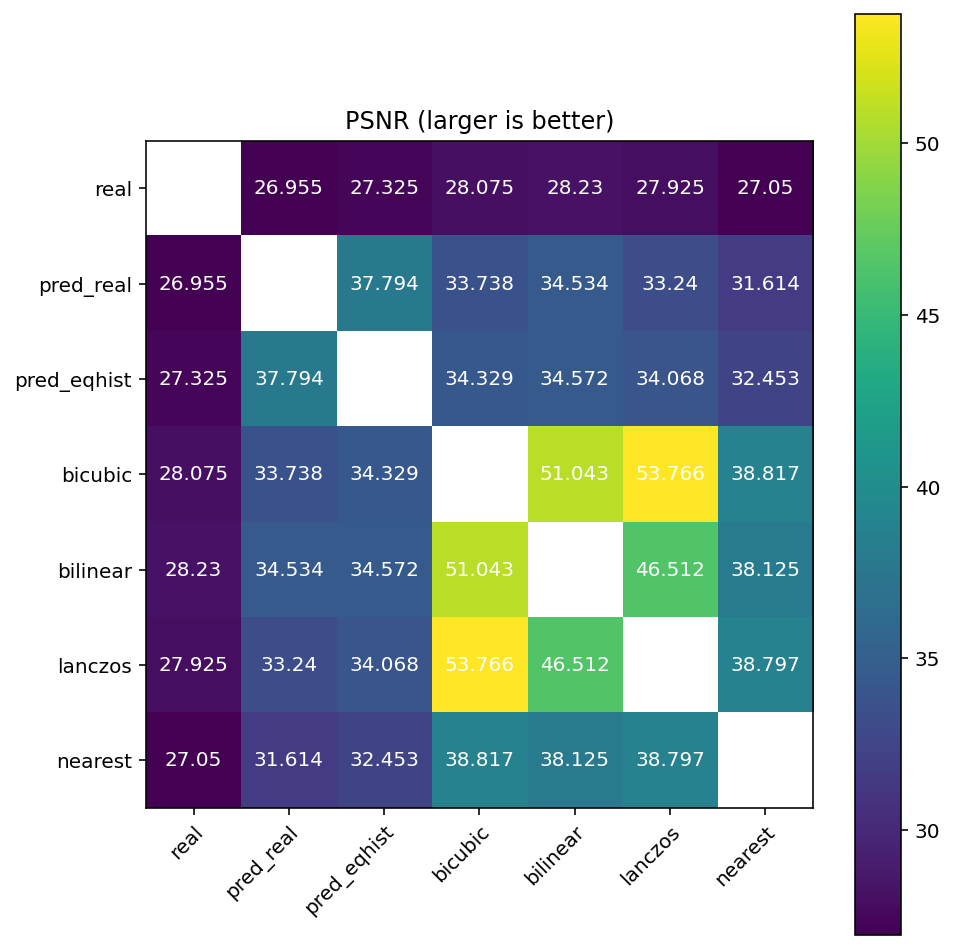

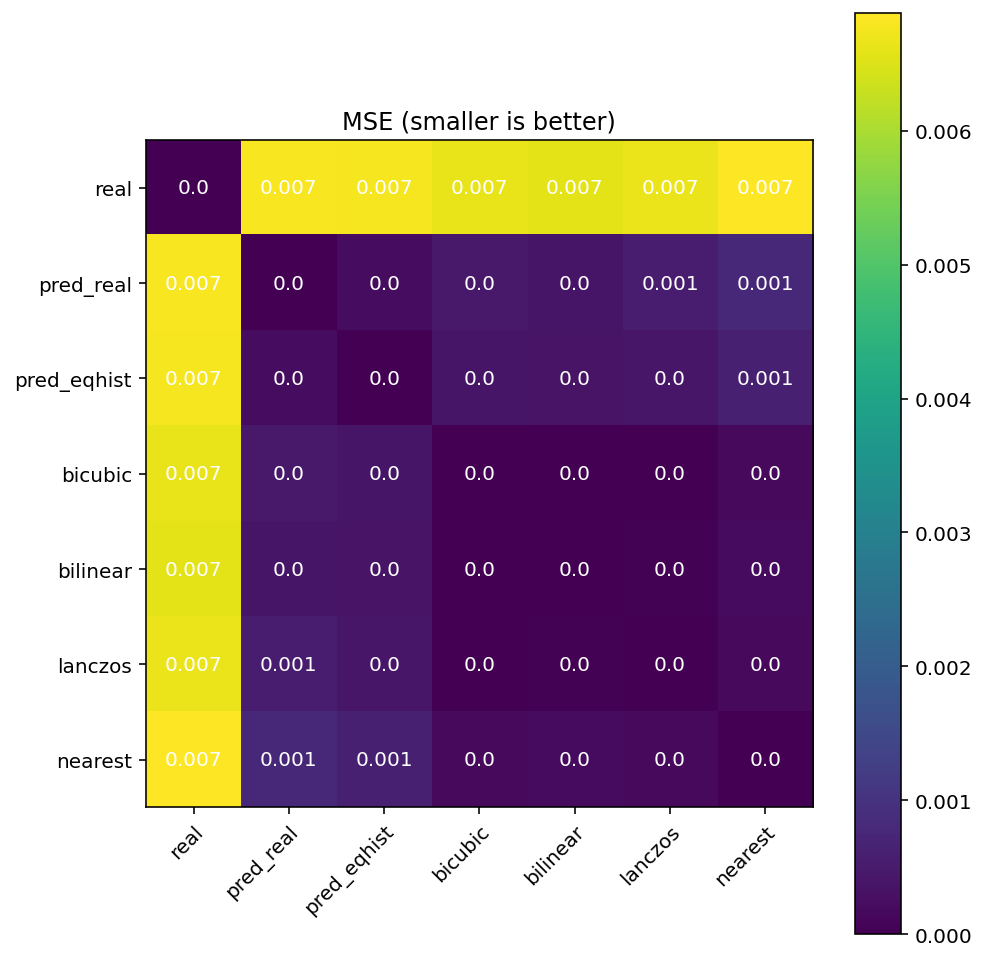

In [4]:
demo_heatmap('data/dat-red-one-per-scene.npy',
             ('log/model-20-07-21-18:28:38-red-real.h5',
              'log/model-20-07-21-20:14:09-red-eqhist.h5'))